### CMP637-GenAI Assignment-phase1 ## DR. Yahia
# Asmaa Qandeel Ali - 202211150
##### Jan 2026

In [1]:
# Note: Don't import any other libraries for deep learning or ML in general.
import math
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

# If you wish, you can include other libraries related to side tasks
# such as drawing images, showing a progress bar, etc.
import matplotlib.pyplot as plt
from tqdm import tqdm
import wandb

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

## Define utility functions

In [2]:
# Note: If you wish to add or modify some utility functions, feel free to do so.

# You can change this variable to choose between discrete and continuous images
# In the discrete case, the image channels are of type uint8 with values from 0 to 255
# In the continous case, the image channels are of type float with values from 0 to 1
use_discrete_data = False

# Show a batch of images x and their corresponding classes y
# Params:
# - x: A tensor of shape [Batch Size, 1, Height, Width] and type float
# - y: A tensor of shape [Batch Size] and type int64
def show_images(x: torch.Tensor, y: torch.Tensor):
  # Convert images to a color uint8 numpy array
  #first unflatten the tensor
  x = x.view(x.shape[0], 1, 28, 28)
  if use_discrete_data:
    x = x[:, 0].clamp(0,255).cpu().numpy()
    x = np.stack([x.astype(np.uint8)]*3, axis=-1)
  else:
    x = x[:, 0].clamp(0,1).cpu().numpy()
    x = np.stack([(x * 255).astype(np.uint8)]*3, axis=-1)
  # Calculate the number of rows and columns to organize the images
  count = x.shape[0]
  rows = max(1, int(count ** 0.5))
  columns = max(1, count // rows)
  # Draw a grid or images
  plt.figure(figsize=(columns, rows))
  for i in range(count):
    plt.subplot(rows, columns, i+1)
    plt.imshow(x[i])
    plt.axis('off')
    plt.title(f"Class: {y[i]}", fontsize=10)
  plt.subplots_adjust(wspace=0.3, hspace=0.7, left=0.1, right=0.9, top=0.9, bottom=0.1)
  plt.show()

 ## Load and visualize the dataset
 I added image Flattening

In [3]:
# TODO [Optional]: You can modify the transforms.
# Note: If you modify the transforms, you may need to modify the `show_images` function.
if use_discrete_data:
  transform = transforms.Compose([
      transforms.PILToTensor(),
      transforms.Lambda(lambda t: t.view(-1))            ## (1,28,28) => (784,)
  ])
else:
  transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Lambda(lambda t: t.view(-1))            ## (1,28,28) => (784,)
  ])

# This will load the dataset into the folder "datasets" the first time it is run
dataset = torchvision.datasets.MNIST(root="datasets", download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 44.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.10MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.1MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.19MB/s]


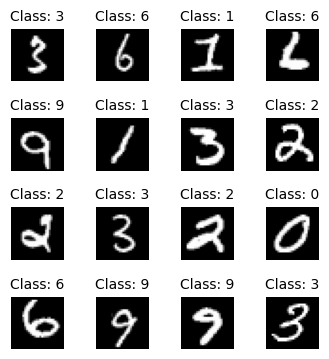

In [4]:
def show_dataset_sample(sample_size: int = 100):
  # sample_size must be a square number so the grid is all full
  loader = DataLoader(dataset, batch_size=sample_size, shuffle=True)
  x, y = next(iter(loader))
  x = x.view(sample_size, 1, 28, 28)
  y = y.view(sample_size)
  show_images(x, y)

show_dataset_sample(sample_size=16)

## Define the model

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ------------------------
# Generator
# ------------------------
class Generator(nn.Module):
    def __init__(self, latent_dim=100, num_classes=10, img_dim=28*28):
        super().__init__()
        self.latent_dim = latent_dim

        self.model = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, img_dim),
            nn.Sigmoid()   # output in [0,1]
        )

    def forward(self, z, y):
        y = y.to(z.device)
        x = torch.cat([z, y], dim=1)
        return self.model(x)

    
    @torch.no_grad()
    def sample(self, y):
       """
        y: [n_samples, 10] one-hot
        """
        n_samples = y.size(0)
    
        y = y.to(device)
        # y_onehot = F.one_hot(labels, num_classes=10).float()
    
        z = torch.randn(n_samples, self.latent_dim, device=y.device) 
        return self.forward(z, y)
# ------------------------
# Discriminator
# ------------------------
class Discriminator(nn.Module):
    def __init__(self, num_classes=10, img_dim=28*28):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(img_dim + num_classes, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x, y):
        y = y.to(x.device)
        x = torch.cat([x, y], dim=1)
        return self.model(x)


# Instantiate model and optim
# Trainig

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

latent_dim = 100
num_classes = 10
img_dim = 28*28

G = Generator(latent_dim, num_classes, img_dim).to(device)
D = Discriminator(num_classes, img_dim).to(device)

optimizer_G = torch.optim.Adam(G.parameters(), lr=1e-4, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(D.parameters(), lr=1e-4, betas=(0.5, 0.999))

criterion = nn.BCELoss()

train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [8]:
g_loss = []
d_loss = []
epochs = 10
for epoch in range(epochs):
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}"):

        # -----------------
        # Prepare data
        # -----------------
        x = x.to(device).view(x.size(0), -1)      # [B,784]
        y = y.to(device)
        y_onehot = F.one_hot(y, num_classes=10).float().to(device)

        batch_size = x.size(0)

        valid = torch.ones(batch_size, 1, device=device)
        fake  = torch.zeros(batch_size, 1, device=device)

        # -----------------
        #  Train Discriminator
        # -----------------
        optimizer_D.zero_grad()

        # Real images
        real_pred = D(x, y_onehot)
        loss_real = criterion(real_pred, valid)

        # Fake images
        z = torch.randn(batch_size, latent_dim, device=device) * 0.5
        fake_imgs = G(z, y_onehot).detach()   # detach so G isn't trained here
        fake_pred = D(fake_imgs, y_onehot)
        loss_fake = criterion(fake_pred, fake)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        z = torch.randn(batch_size, latent_dim, device=device)
        gen_imgs = G(z, y_onehot)
        pred = D(gen_imgs, y_onehot)

        # want discriminator to think generated images are "real"
        loss_G = criterion(pred, valid)

        loss_G.backward()
        optimizer_G.step()

    print(
        f"Epoch [{epoch+1}/{epochs}] "
        f"D loss: {loss_D.item():.4f} | G loss: {loss_G.item():.4f}"
    )
    
    g_loss.append(loss_G.item())
    d_loss.append(loss_D.item())

Epoch 0/10: 100%|██████████| 938/938 [00:12<00:00, 73.17it/s]


Epoch [1/10] D loss: 0.1675 | G loss: 4.5330


Epoch 1/10: 100%|██████████| 938/938 [00:11<00:00, 78.96it/s]


Epoch [2/10] D loss: 0.1262 | G loss: 4.7202


Epoch 2/10: 100%|██████████| 938/938 [00:11<00:00, 83.41it/s]


Epoch [3/10] D loss: 0.0439 | G loss: 6.9368


Epoch 3/10: 100%|██████████| 938/938 [00:11<00:00, 84.31it/s]


Epoch [4/10] D loss: 0.0611 | G loss: 5.1771


Epoch 4/10: 100%|██████████| 938/938 [00:11<00:00, 85.15it/s]


Epoch [5/10] D loss: 0.1408 | G loss: 6.0655


Epoch 5/10: 100%|██████████| 938/938 [00:11<00:00, 84.35it/s]


Epoch [6/10] D loss: 0.0160 | G loss: 6.6117


Epoch 6/10: 100%|██████████| 938/938 [00:11<00:00, 83.38it/s]


Epoch [7/10] D loss: 0.2133 | G loss: 12.3540


Epoch 7/10: 100%|██████████| 938/938 [00:11<00:00, 84.87it/s]


Epoch [8/10] D loss: 0.0675 | G loss: 10.9247


Epoch 8/10: 100%|██████████| 938/938 [00:11<00:00, 84.34it/s]


Epoch [9/10] D loss: 0.0110 | G loss: 7.3101


Epoch 9/10: 100%|██████████| 938/938 [00:11<00:00, 84.89it/s]

Epoch [10/10] D loss: 0.0001 | G loss: 10.4689


# Plot the loss function
for more detailed report visit my wandb report here to show all the loss and training experiments.

Well, not all, but the last working ones :-D

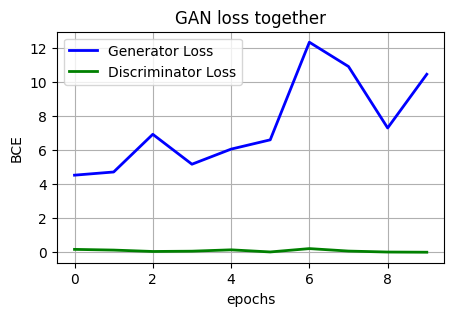

In [13]:
plt.figure(figsize=(5, 3))
plt.plot(g_loss, label='Generator Loss', color='blue', linewidth=2)
plt.plot(d_loss, label='Discriminator Loss', color='green', linewidth=2)

plt.title('GAN loss together')
plt.xlabel('epochs')
plt.ylabel('BCE')
plt.legend()
plt.grid(True)
plt.show()

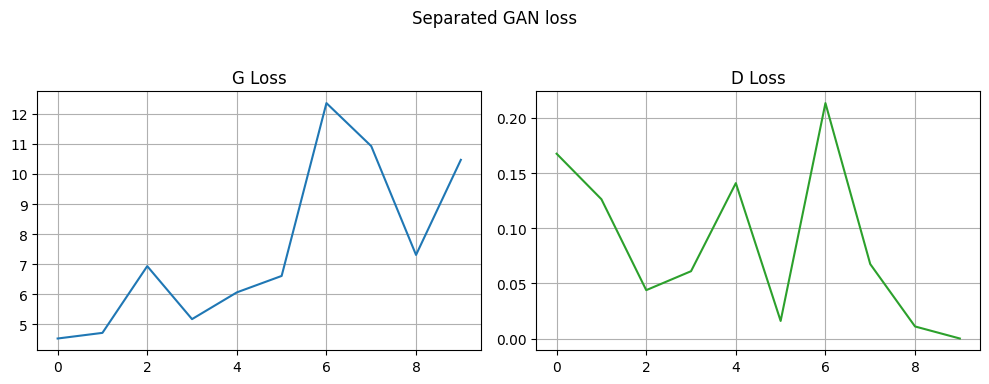

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(g_loss, 'tab:blue')
axs[0].set_title('G Loss')
axs[0].grid(True)

axs[1].plot(d_loss, 'tab:green')
axs[1].set_title('D Loss')
axs[1].grid(True)

# 5. Add a main title for the entire figure and adjust layout
plt.suptitle('Separated GAN loss')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

## [Optional] Save and/or load the model

In [ ]:
# ## Optional TODO: Save the model if you want to store your work on disk and load it later
# torch.save(model.state_dict(), "made_temp.pth")

# loaded_model = ContinuousConditionalMADE(
#     input_size=input_dim,
#     cond_size=10,
#     hidden_sizes=hidden_dim,
# )
# # loaded_model = ConditionalMADE(input_size=input_dim,
# #                         cond_size=10,
# #                         hidden_sizes=hidden_dim,
# #                         natural_ordering=True)
# loaded_model.load_state_dict(torch.load("made_temp.pth"))

## Generate some images and display them

In [22]:
import torch
import torch.nn.functional as F

@torch.no_grad()
def sample_cgan(G, labels, latent_dim=100, device="cpu"):
    """
    labels: 1D tensor of class indices (e.g., [3,3,3,3])
    """
    G.eval()

    labels = labels.to(device)
    y_onehot = F.one_hot(labels, num_classes=10).float()

    z = torch.randn(labels.size(0), latent_dim, device=device)

    samples = G(z, y_onehot)
    return samples.view(-1, 1, 28, 28)
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
y = torch.tensor([i for _ in range(10) for i in range(10)], dtype=torch.long)

labels = y
imgs = sample_cgan(G, labels, latent_dim=100, device=device)
show_images(imgs, labels)

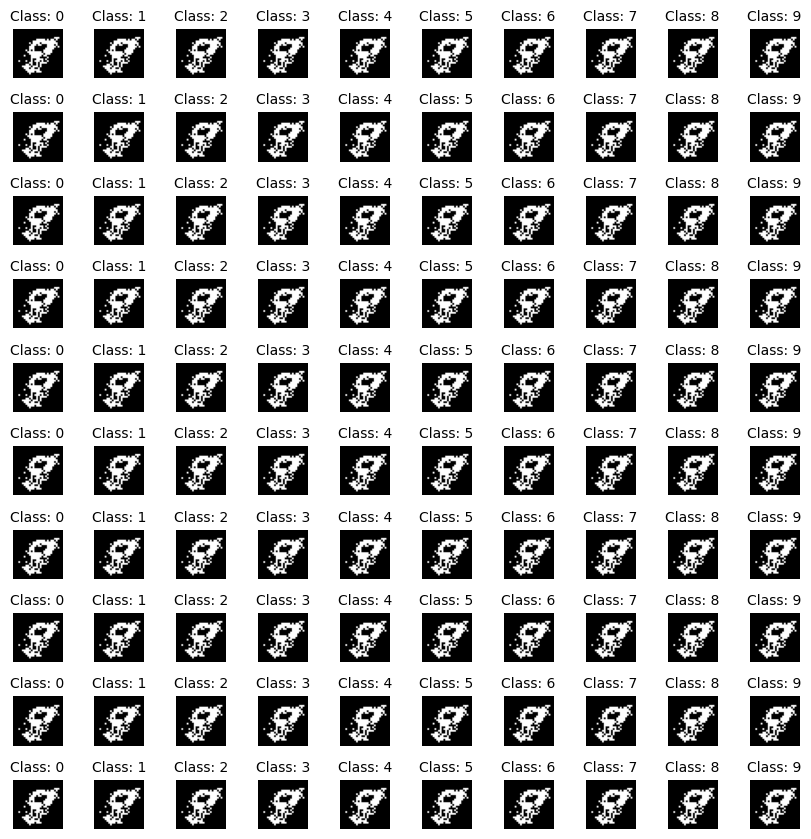

In [18]:
def generate(y: torch.Tensor) -> torch.Tensor:
    y_cond =  nn.functional.one_hot(y, num_classes=10).float().to(device)
    model = G
    model.eval() # put model in evaluation mode
    new_x = model.sample(y_cond)
    return new_x
    
# Generate 100 images (10 images per class x 10 classes)
y = torch.tensor([i for _ in range(10) for i in range(10)], dtype=torch.long)

x = generate(y)
show_images(x, y)

AttributeError: 'Generator' object has no attribute 'sample'

## [Optional] Extras

You can do any extra stuff you want here. Some examples are:
* Draw a graph of the loss functions.
* Implement interpolation in latent space (You can try it with Normalizing flows, Latent variable models and Implicit models).
* Implement image in-painting (You can try it with Score-based models, and in a limited form with Autoregressive models too).
* Visualize the generation process (You can try it with Energy-based and Score-based models).